In [1]:
# Проверим видео карту
!nvidia-smi

Thu Jan 28 22:03:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Склонируем репозитарий
!git clone https://github.com/fizyr/keras-retinanet.git


Cloning into 'keras-retinanet'...
remote: Enumerating objects: 6205, done.
remote: Total 6205 (delta 0), reused 0 (delta 0), pack-reused 6205
Receiving objects: 100% (6205/6205), 14.87 MiB | 41.83 MiB/s, done.
Resolving deltas: 100% (4195/4195), done.


In [3]:
# Обновим керас
!pip install --upgrade keras


Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.4.3)


In [4]:
%cd keras-retinanet/
!pip install .

/content/keras-retinanet
Processing /content/keras-retinanet
  Created wheel for keras-retinanet: filename=keras_retinanet-1.0.0-cp36-cp36m-linux_x86_64.whl size=167010 sha256=ee283004ff83dc4f5f36556bd464ba18b043273a2f6a2aed73c9471434588721
  Stored in directory: /root/.cache/pip/wheels/b2/9f/57/cb0305f6f5a41fc3c11ad67b8cedfbe9127775b563337827ba
  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=20486 sha256=0ef842fc5b3795584644848b874f16299638e1deb4cf69d22858b7ca5d4c291b
  Stored in directory: /root/.cache/pip/wheels/5f/09/a5/497a30fd9ad9964e98a1254d1e164bcd1b8a5eda36197ecb3c
Successfully built keras-retinanet keras-resnet


In [5]:
!python setup.py build_ext --inplace
!pip install gdown
!pip install tensorflow-gpu

running build_ext
cythoning keras_retinanet/utils/compute_overlap.pyx to keras_retinanet/utils/compute_overlap.c
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/keras-retinanet/keras_retinanet/utils/compute_overlap.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'keras_retinanet.utils.compute_overlap' extension
creating build
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/keras_retinanet
creating build/temp.linux-x86_64-3.6/keras_retinanet/utils
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/include/python3.6m -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -c keras_retinanet/utils/compute_overlap.c -o build/temp.linux-x86_64-3.6/keras_retinanet/utils/compute_over

In [7]:
# Импортируем библиотеки
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
import urllib
import os
import csv
import cv2
import time
from PIL import Image
import warnings

from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
warnings.filterwarnings('ignore')


In [9]:
# Загрузим keras-retinanet
!gdown --id 1mTtB8GTWs74Yeqm0KMExGJZh1eDbzUlT --output indian_number_plates.json
os.makedirs("snapshots", exist_ok=True)

Downloading...
From: https://drive.google.com/uc?id=1mTtB8GTWs74Yeqm0KMExGJZh1eDbzUlT
To: /content/keras-retinanet/indian_number_plates.json
100% 92.5k/92.5k [00:00<00:00, 33.9MB/s]


In [10]:
!gdown --id 1wPgOBoSks6bTIs9RzNvZf6HWROkciS8R --output snapshots/resnet50_csv_10.h5


Downloading...
From: https://drive.google.com/uc?id=1wPgOBoSks6bTIs9RzNvZf6HWROkciS8R
To: /content/keras-retinanet/snapshots/resnet50_csv_10.h5
249MB [00:02, 94.9MB/s]


In [16]:
plates_df = pd.read_json('indian_number_plates.json', lines=True)
os.makedirs("number_plates", exist_ok=True)

In [18]:
%%time
# Загрузим данные
dataset = dict()
dataset["image_name"] = list()
dataset["x_min"] = list()
dataset["y_min"] = list()
dataset["x_max"] = list()
dataset["y_max"] = list()
dataset["class_name"] = list()

counter = 0
for index, row in plates_df.iterrows():
    img = urllib.request.urlopen(row["content"])
    img = Image.open(img)
    img = img.convert('RGB')
    img.save(f'number_plates/licensed_car_{counter}.jpeg', "JPEG")
    
    dataset["image_name"].append(f'number_plates/licensed_car_{counter}.jpeg')
    data = row["annotation"]
    width = data[0]["imageWidth"]
    height = data[0]["imageHeight"]

    dataset["x_min"].append(int(round(data[0]["points"][0]["x"] * width)))
    dataset["y_min"].append(int(round(data[0]["points"][0]["y"] * height)))
    dataset["x_max"].append(int(round(data[0]["points"][1]["x"] * width)))
    dataset["y_max"].append(int(round(data[0]["points"][1]["y"] * height)))
    dataset["class_name"].append("license_plate")
    
    counter += 1
print("Downloaded {} car images.".format(counter))

Downloaded 237 car images.
CPU times: user 4.96 s, sys: 193 ms, total: 5.15 s
Wall time: 1min 16s


In [15]:
# Посмотрим датасет
df = pd.DataFrame(dataset)
df.head()

image_name  x_min  y_min  x_max  y_max     class_name
0  number_plates/licensed_car_0.jpeg    582    274    700    321  license_plate
1  number_plates/licensed_car_1.jpeg     80    382    288    449  license_plate
2  number_plates/licensed_car_2.jpeg     41    219    115    260  license_plate
3  number_plates/licensed_car_3.jpeg    217    313    359    359  license_plate
4  number_plates/licensed_car_4.jpeg    209    220    866    554  license_plate

In [19]:
# Функция для вывода изображения
def show_image_objects(image_row):

  img_path = image_row.image_name
  box = [image_row.x_min, image_row.y_min, image_row.x_max, image_row.y_max]
  image = read_image_bgr(img_path)
  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
  draw_box(draw, box, color=(255, 255, 0))

  plt.axis('off')
  plt.imshow(draw)
  plt.show()

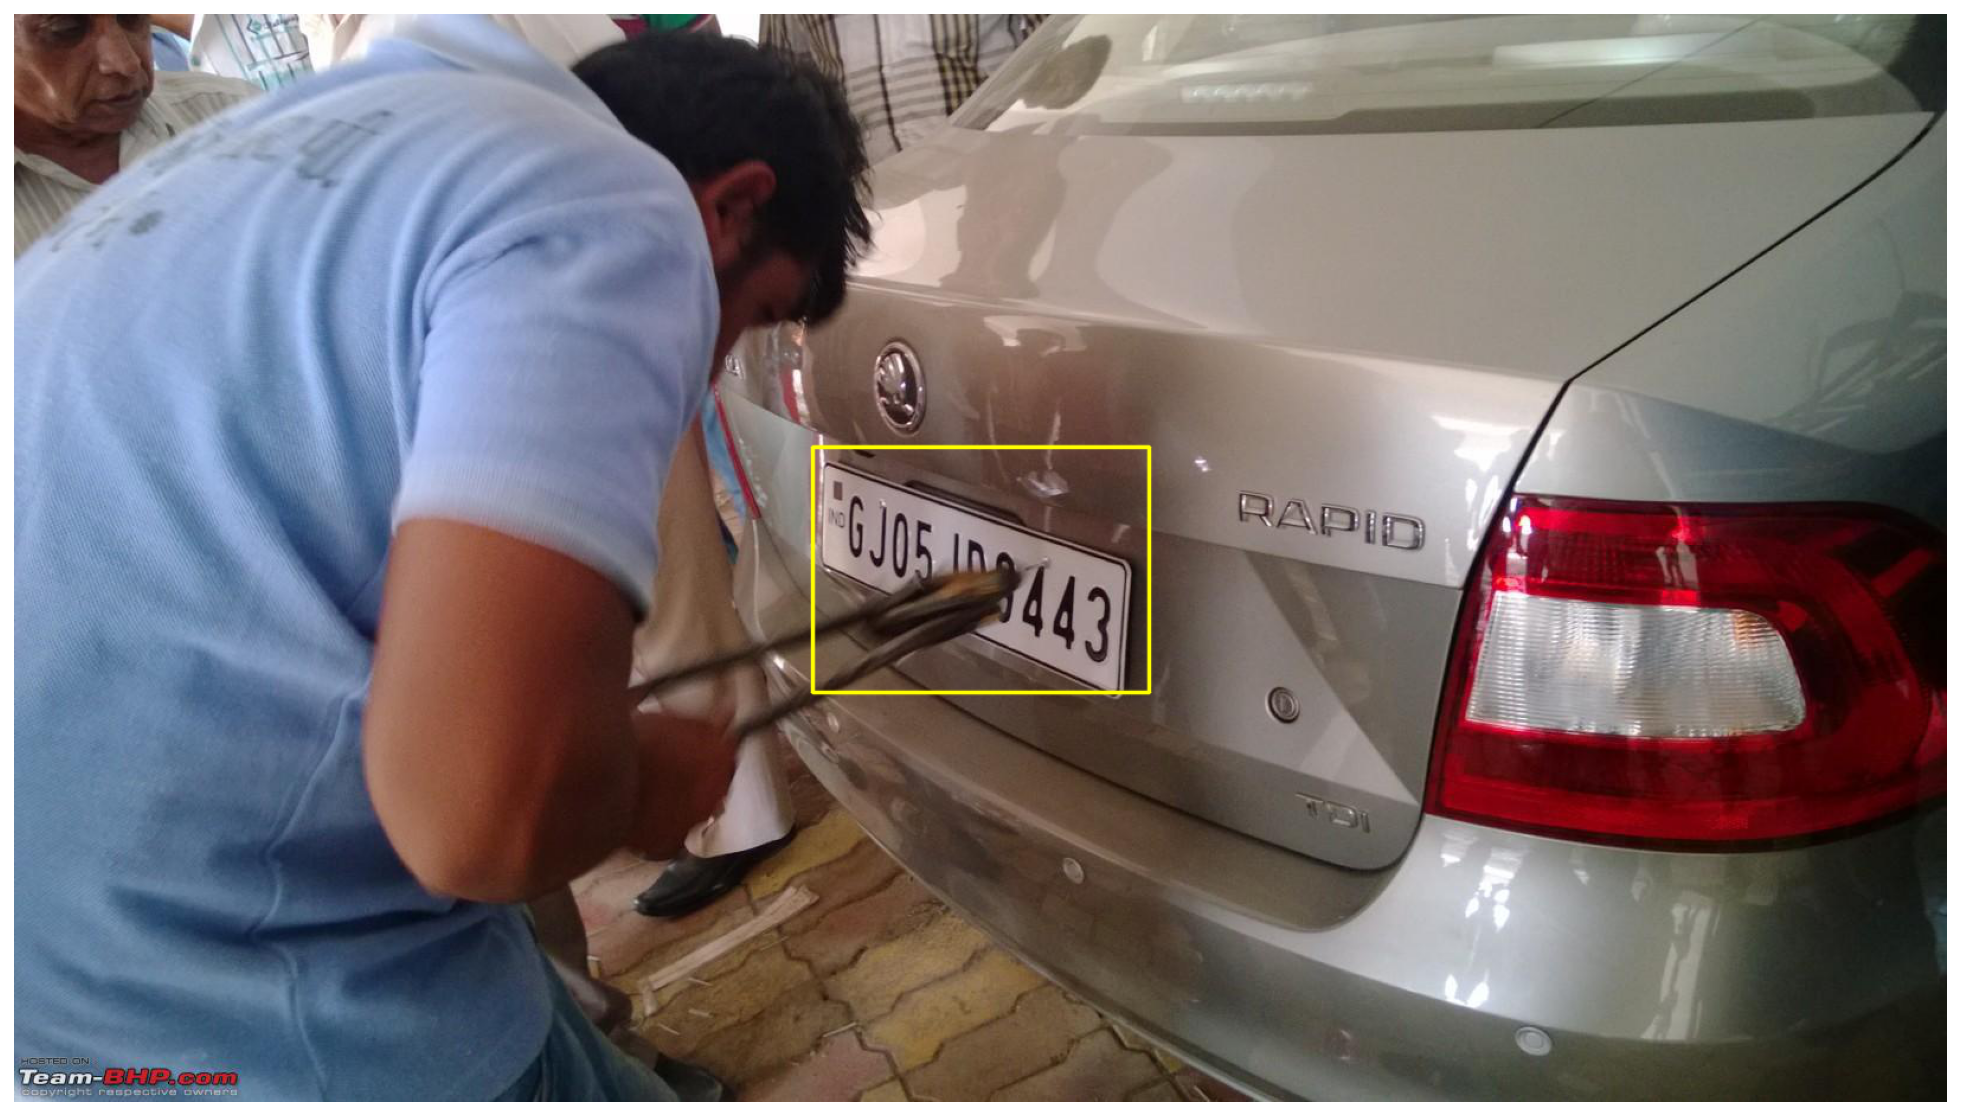

In [21]:
# Выведем изображение
show_image_objects(df.iloc[9])

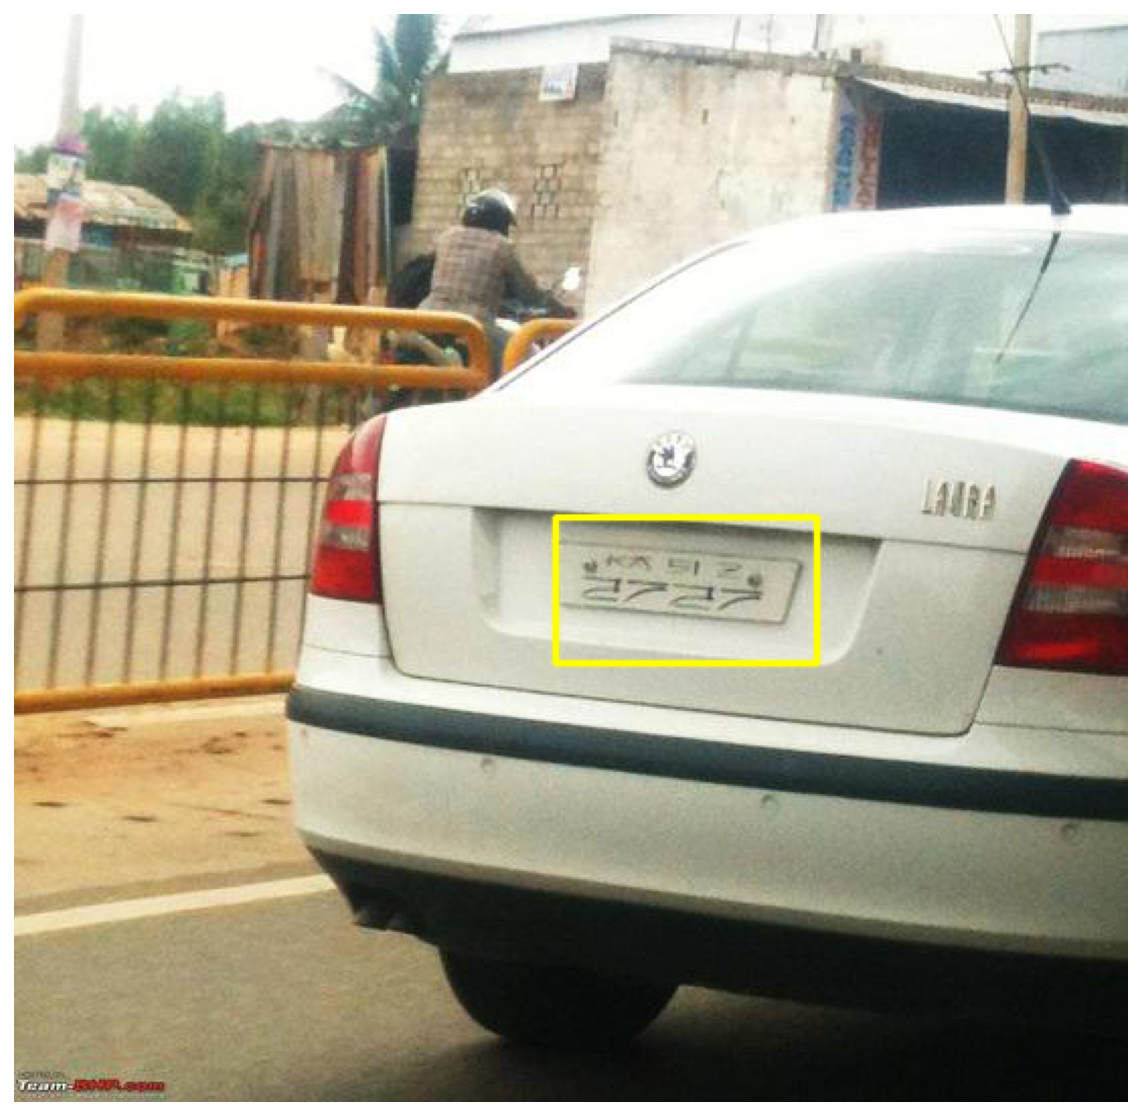

In [22]:
show_image_objects(df.iloc[7])

In [23]:
# Разделим датасет
train_df, test_df = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
ANNOTATIONS_FILE = 'annotations.csv'
CLASSES_FILE = 'classes.csv'

In [25]:
# Запишем данные в csv
train_df.to_csv(ANNOTATIONS_FILE, index=False, header=None)
classes = set(['license_plate'])

with open(CLASSES_FILE, 'w') as f:
  for i, line in enumerate(sorted(classes)):
    f.write('{},{}\n'.format(line,i))

In [26]:
# Выведем основной клаа
!head classes.csv

license_plate,0


In [27]:
# Выведем аннотацию
!head annotations.csv

number_plates/licensed_car_183.jpeg,169,260,358,298,license_plate
number_plates/licensed_car_201.jpeg,251,187,375,234,license_plate
number_plates/licensed_car_230.jpeg,140,149,324,220,license_plate
number_plates/licensed_car_95.jpeg,302,420,671,534,license_plate
number_plates/licensed_car_190.jpeg,115,86,227,117,license_plate
number_plates/licensed_car_84.jpeg,103,209,258,276,license_plate
number_plates/licensed_car_158.jpeg,83,34,369,483,license_plate
number_plates/licensed_car_97.jpeg,123,117,221,170,license_plate
number_plates/licensed_car_147.jpeg,162,227,312,274,license_plate
number_plates/licensed_car_184.jpeg,100,148,259,208,license_plate


In [28]:
# Загрузим предобученную модель
PRETRAINED_MODEL = './snapshots/_pretrained_model.h5'

URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5'
urllib.request.urlretrieve(URL_MODEL, PRETRAINED_MODEL)

print('Downloaded pretrained model to ' + PRETRAINED_MODEL)

Downloaded pretrained model to ./snapshots/_pretrained_model.h5


In [29]:
# Обучим модель на 10 эпохах с размером бача 8 
!keras_retinanet/bin/train.py --freeze-backbone --random-transform --weights {PRETRAINED_MODEL} --batch-size 8 --steps 500 --epochs 10 csv annotations.csv classes.csv

2021-01-28 22:24:53.747551: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2021-01-28 22:24:53.747607: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Creating model, this may take a second...
2021-01-28 22:24:55.711333: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-01-28 22:24:55.712427: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-01-28 22:24:55.760346: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-01-28 22:24:55.760989: I tensorf

In [30]:

!ls snapshots

_pretrained_model.h5  resnet50_csv_10.h5


In [31]:
model_path = os.path.join('snapshots', sorted(os.listdir('snapshots'), reverse=True)[0])
print(model_path)

model = models.load_model(model_path, backbone_name='resnet50')
model = models.convert_model(model)

labels_to_names = pd.read_csv(CLASSES_FILE, header=None).T.loc[0].to_dict()

snapshots/resnet50_csv_10.h5


In [34]:
THRES_SCORE = 0.6

# Функция предикта
def predict(image):
  image = preprocess_image(image.copy())
  image, scale = resize_image(image)
  boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
  boxes /= scale

  return boxes, scores, labels

# Функция отрисовка бокса
def draw_detections(image, boxes, scores, labels):
  for box, score, label in zip(boxes[0], scores[0], labels[0]):
    if score < THRES_SCORE:
        break
    color = label_color(label)
    b = box.astype(int)
    draw_box(image, b, color=color)
    caption = "{} {:.3f}".format(labels_to_names[label], score)
    draw_caption(image, b, caption)

# Функция вывода детектированных объектов
def show_detected_objects(image_row):
  img_path = image_row.image_name
  image = read_image_bgr(img_path)
  boxes, scores, labels = predict(image)
  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
  true_box = [image_row.x_min, image_row.y_min, image_row.x_max, image_row.y_max]
  draw_box(draw, true_box, color=(255, 255, 0))
  draw_detections(draw, boxes, scores, labels)

  plt.axis('off')
  plt.imshow(draw)
  plt.show()

In [35]:
# Тестовый датасет
test_df.head(n=10)

image_name  x_min  ...  y_max     class_name
115  number_plates/licensed_car_115.jpeg     48  ...    188  license_plate
15    number_plates/licensed_car_15.jpeg    274  ...    431  license_plate
211  number_plates/licensed_car_211.jpeg    157  ...    160  license_plate
126  number_plates/licensed_car_126.jpeg    443  ...    347  license_plate
6      number_plates/licensed_car_6.jpeg    227  ...    315  license_plate
170  number_plates/licensed_car_170.jpeg    556  ...   1079  license_plate
9      number_plates/licensed_car_9.jpeg    674  ...    572  license_plate
221  number_plates/licensed_car_221.jpeg     93  ...    406  license_plate
112  number_plates/licensed_car_112.jpeg     22  ...    362  license_plate
220  number_plates/licensed_car_220.jpeg     55  ...    238  license_plate

[10 rows x 6 columns]

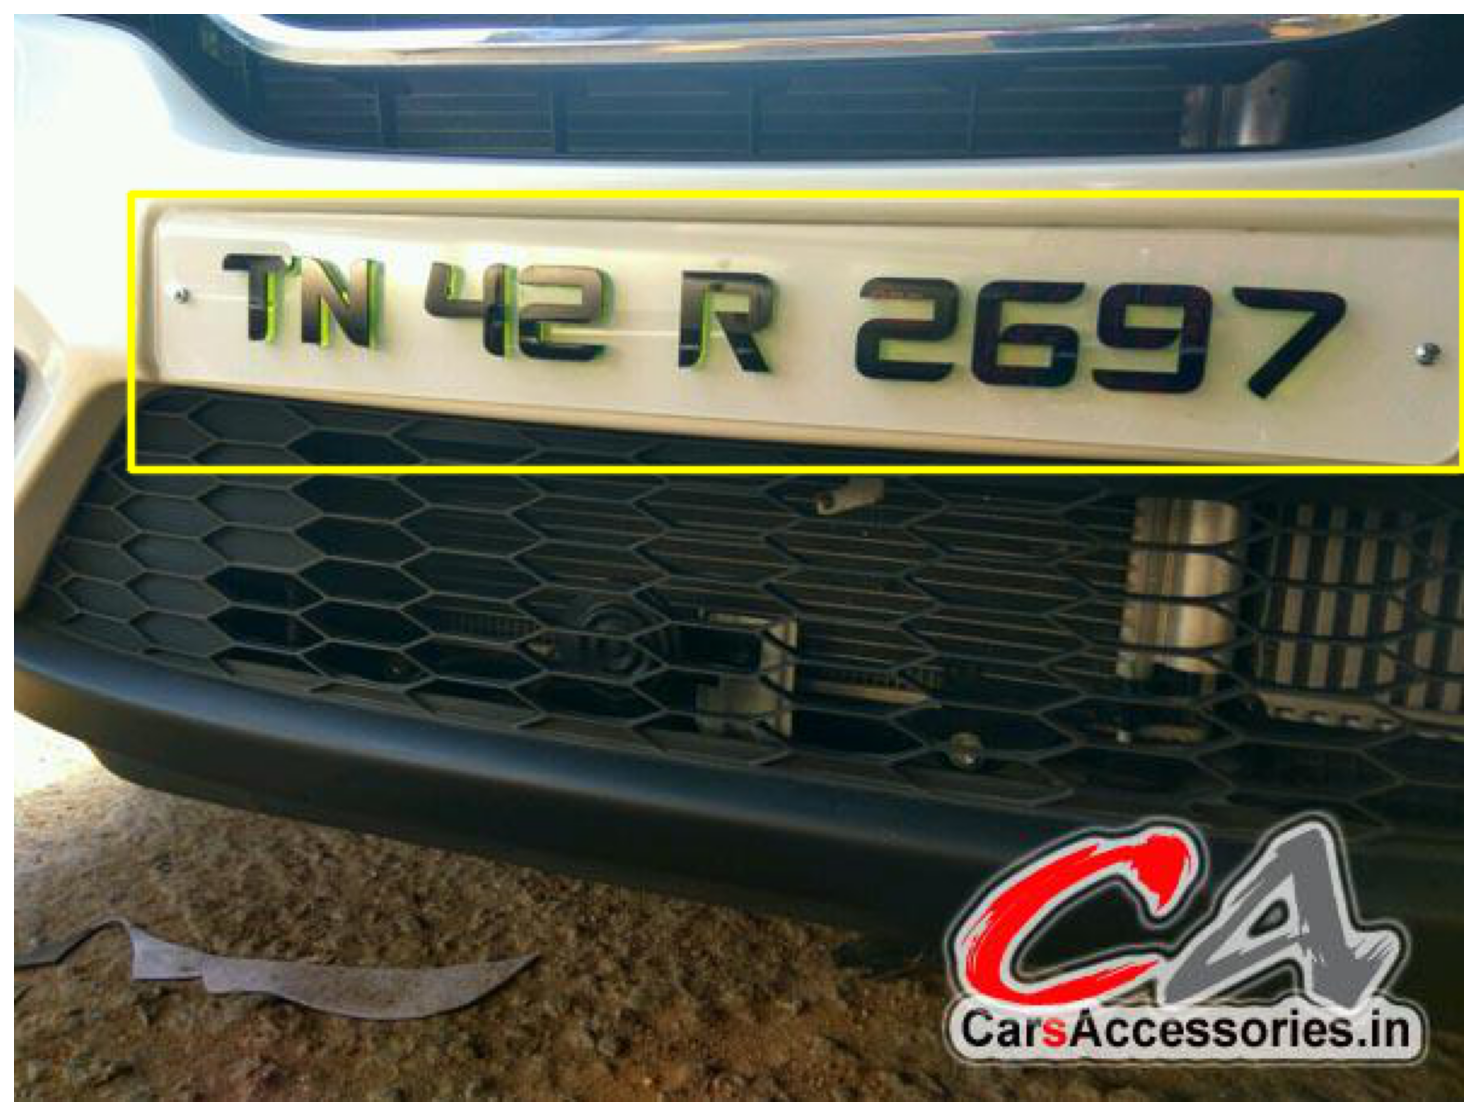

In [36]:
# Результат на тестовом датасете
show_detected_objects(test_df.iloc[0])

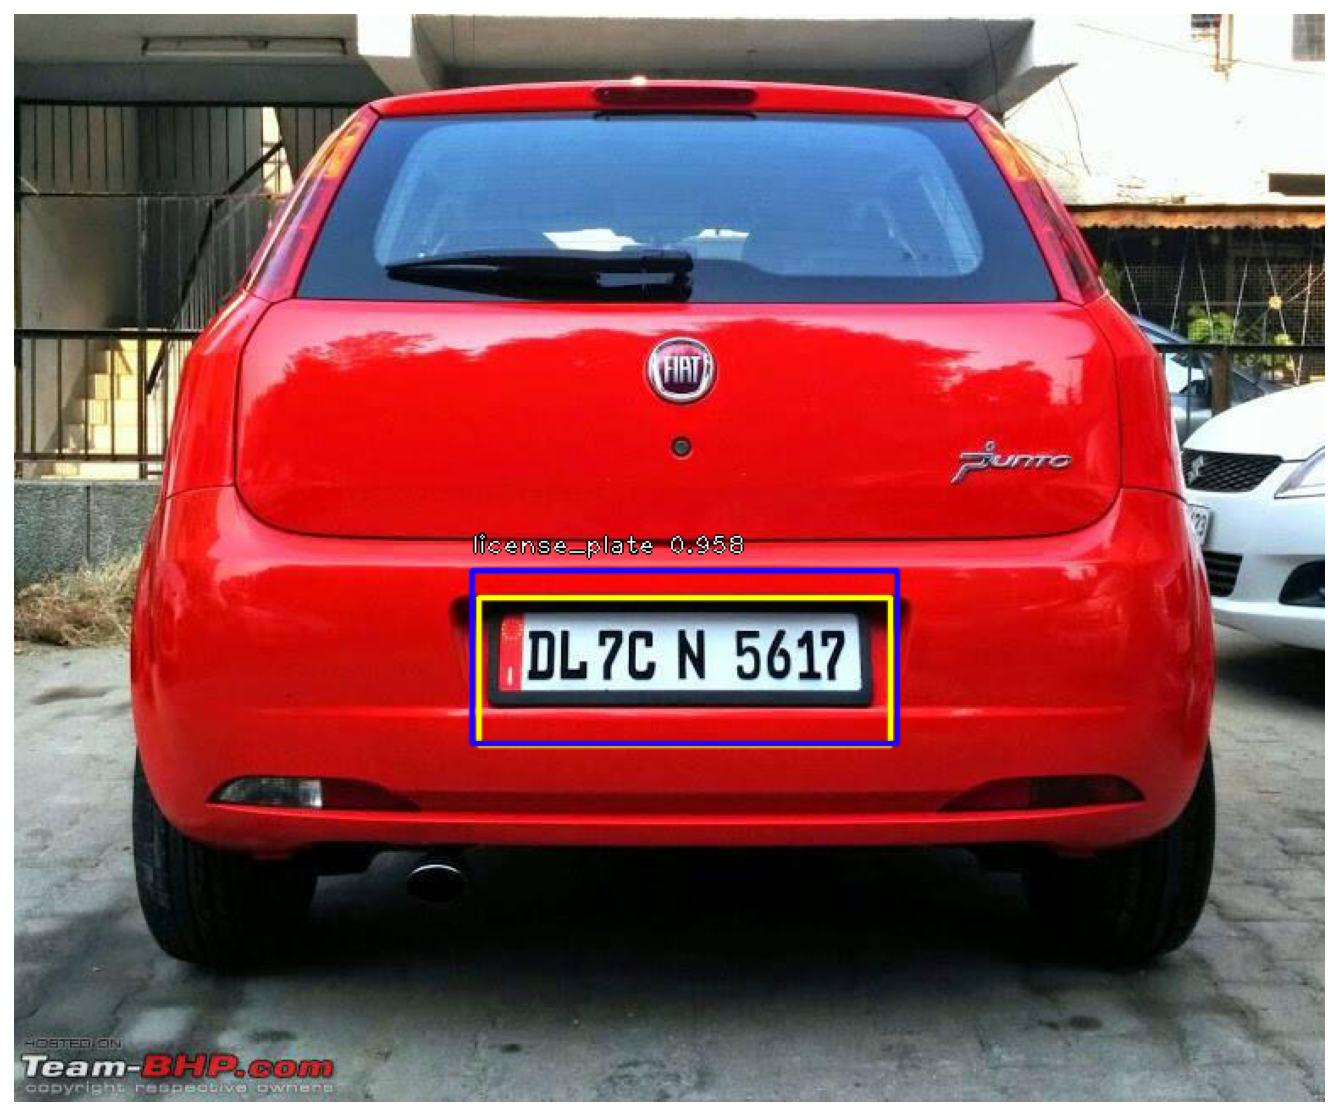

In [37]:
# Результат на тестовом датасете
show_detected_objects(test_df.iloc[1])

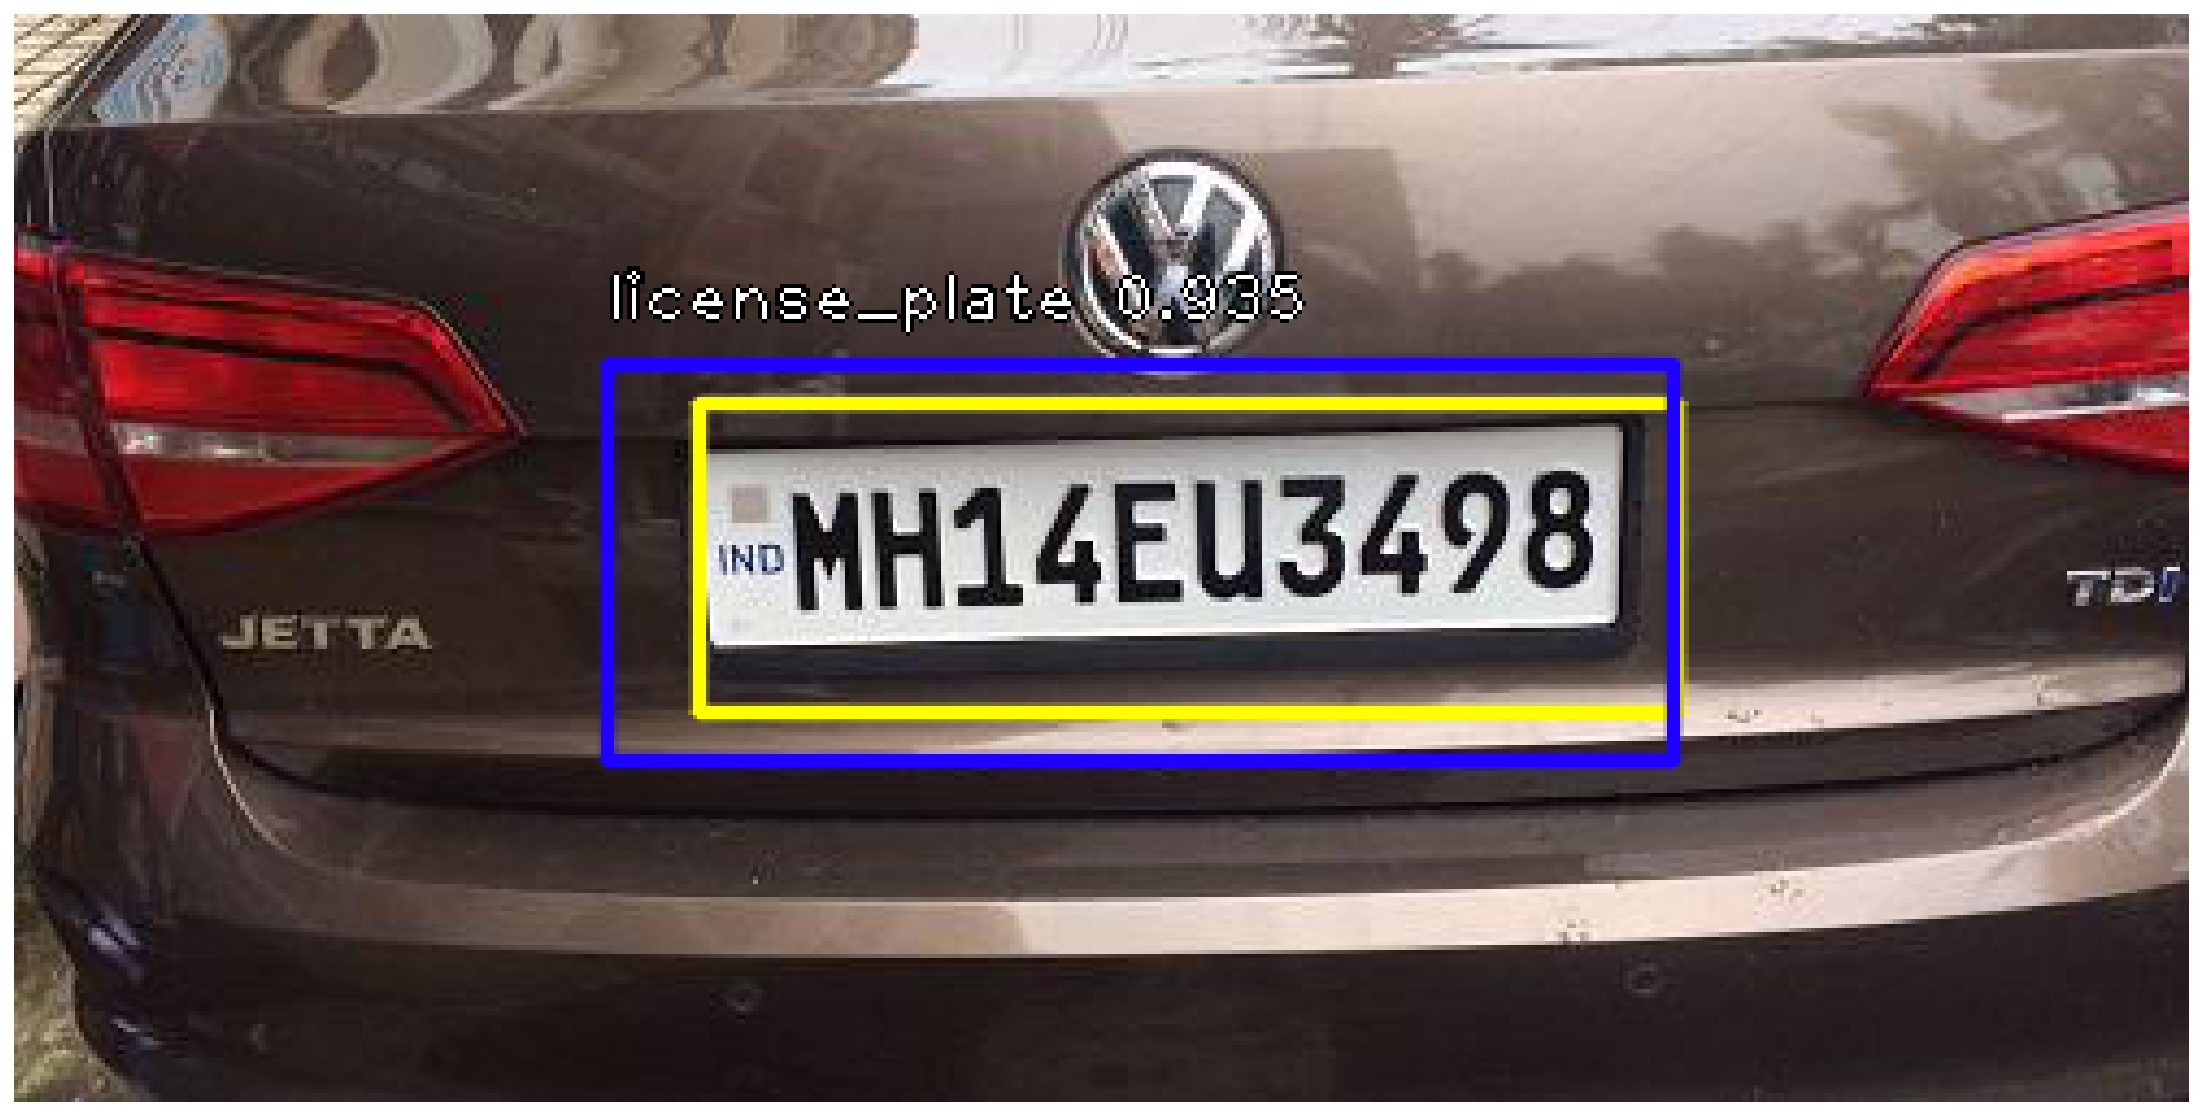

In [38]:
# Результат на тестовом датасете
show_detected_objects(test_df.iloc[2])